In [1]:
# HIDDEN
from datascience import *
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pylab as pl
import math
from scipy import stats

In [2]:
# HIDDEN

def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    "Compute r."
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

In the last section, we developed the concepts of correlation and regression as ways to describe data. We will now see how these concepts can become powerful tools for prediction, when used appropriately. In particular, given paired observations of two quantities and some additional observations of only the first quantity, we can infer typical values for the second quantity.

## Assumptions of randomness: a "regression model"

Prediction is possible if we believe that a scatter plot reflects the underlying relation between the two variables being plotted, but does not specify the relation completely. For example, a scatter plot of the heights of fathers and sons shows us the precise relation between the two variables in one particular sample of men; but we might wonder whether that relation holds true, or almost true, among all fathers and sons in the population from which the sample was drawn, or indeed among fathers and sons in general.

As always, inferential thinking begins with a careful examination of the assumptions about the data. Sets of assumptions are known as *models*. Sets of assumptions about randomness in roughly linear scatter plots are called *regression models*.

In brief, such models say that the underlying relation between the two variables is perfectly linear; this straight line is the *signal* that we would like to identify. However, we are not able to see the line clearly, because there is additional variability in the data beyond the relation. What we see are points that are scattered around the line. For each of the points, the linear signal that relates the two variables has been combined with some other source of variability that has nothing to do with the relation at all. This *random noise* obfuscates the linear signal, and it is our inferential goal to identify the signal despite the noise.

In order to make these statements more precise, we will use the `np.random.normal` function, which generates samples from a normal distribution with 0 mean and 1 standard deviation. These samples correspond to a bell-shaped distribution expressed in standard units.

In [3]:
np.random.normal()

-0.6423537870160524

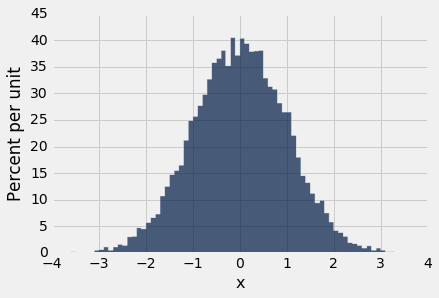

In [4]:
samples = Table('x')
for i in np.arange(10000):
    samples.append([np.random.normal()])
samples.hist(0, bins=np.arange(-4, 4, 0.1))

The regression model specifies that the points in a scatter plot, measured in standard units, are generated at random as follows.

- The `x` are sampled from the normal distribution.

- For each `x`, its corresponding `y` is sampled using the `signal_and_noise` function below, which takes `x` and a correlation coefficient `r`.

In [5]:
def signal_and_noise(x, r):
    return r * x + np.random.normal()

For example, if we choose `r` to be a half, then the following scatter diagram might result.

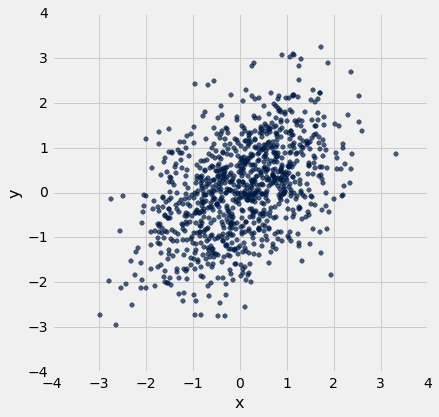

In [6]:
def regression_model(r, sample_size):
    pairs = Table(['x', 'y'])
    for i in np.arange(sample_size):
        x = np.random.normal()
        y = signal_and_noise(x, r)
        pairs.append([x, y])
    return pairs

regression_model(1/2, 1000).scatter('x', 'y')

Based on this scatter plot, how should we estimate the true line? The best line that we can put through a scatter plot is the regression line. So the regression line is a natural estimate of the true line. 

The simulation below draws both the true line used to generate the data (green) and the regression line (blue) found by analyzing the pairs that were generated.

The true r is  0.5  and the estimated r is  0.459672161067


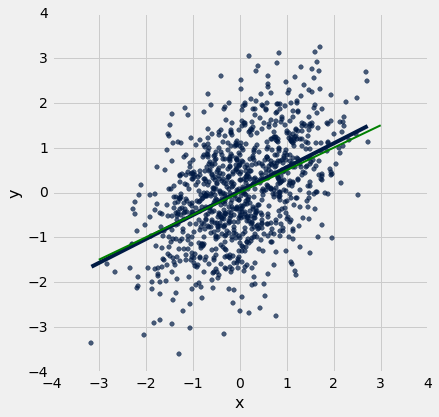

In [7]:
def compare(true_r, sample_size):
    pairs = regression_model(true_r, sample_size)
    estimated_r = correlation(pairs, 'x', 'y')
    pairs.scatter('x', 'y', fit_line=True)
    plt.plot([-3, 3], [-3 * true_r, 3 * true_r], color='g', lw=2)
    print("The true r is ", true_r, " and the estimated r is ", estimated_r)

compare(0.5, 1000)

With 1000 samples, we see that the true line and the regression line are quite similar. With fewer samples, the regression estimate of the true line that generated the data may be quite different.

The true r is  0.5  and the estimated r is  0.357274460168


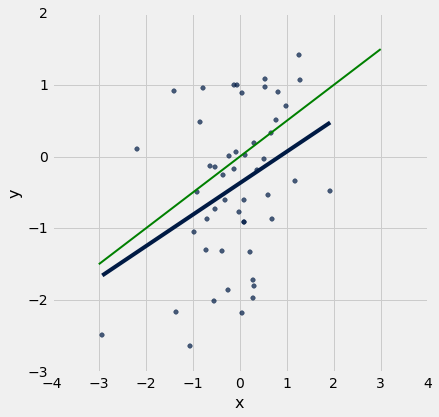

In [8]:
compare(0.5, 50)

With very few samples, the regression line may have a clear positive or negative slope, even when the true relationship has a correlation of 0.

The true r is  0  and the estimated r is  0.501582566452


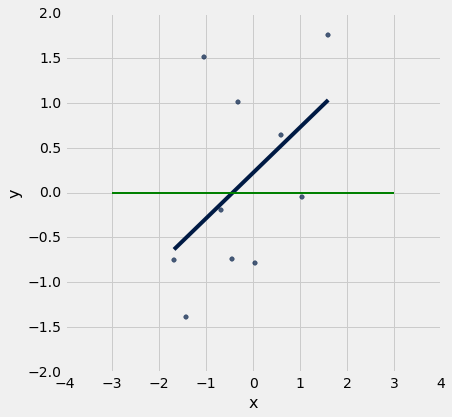

In [9]:
compare(0, 10)

With real data, we will never observe the true line. In fact, regression is often applied when we are uncertain whether the true relation between two quantities is linear at all.  What the simulation shows that if the regression model looks plausible, and we have a large sample, then regression line is a good approximation to the true line.

## Predictions

Here is an example where regression model can be used to make predictions.

The data are a subset of the information gathered in a randomized controlled trial about treatments for Hodgkin's disease. Hodgkin's disease is a cancer that typically affects young people. The disease is curable but the treatment is very harsh. The purpose of the trial was to come up with dosage that would cure the cancer but minimize the adverse effects on the patients. 

This table ``hodgkins`` contains data on the effect that the treatment had on the lungs of 22 patients. The columns are:

- Height in cm
- A measure of radiation to the mantle (neck, chest, under arms)
- A measure of chemotherapy
- A score of the health of the lungs at baseline, that is, at the start of the treatment; higher scores correspond to more healthy lungs
- The same score of the health of the lungs, 15 months after treatment

In [10]:
hodgkins = Table.read_table('hodgkins.csv')
hodgkins.show()

height,rad,chemo,base,month15
164,679,180,160.57,87.77
168,311,180,98.24,67.62
173,388,239,129.04,133.33
157,370,168,85.41,81.28
160,468,151,67.94,79.26
170,341,96,150.51,80.97
163,453,134,129.88,69.24
175,529,264,87.45,56.48
185,392,240,149.84,106.99
178,479,216,92.24,73.43


It is evident that the patients' lungs were less healthy 15 months after the treatment than at baseline. At 36 months, they did recover most of their lung function, but those data are not part of this table.

The scatter plot below shows that taller patients had higher scores at 15 months. 

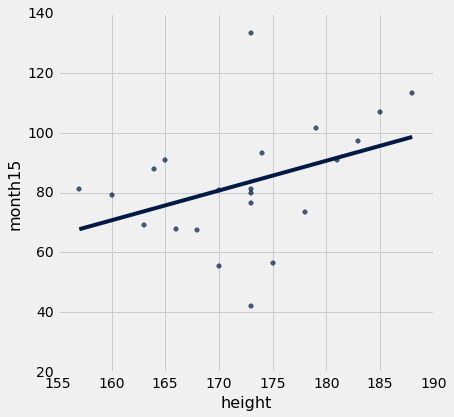

In [11]:
hodgkins.scatter('height', 'month15', fit_line=True)

The scatter plot looks roughly linear. Let us assume that the regression model holds. Under that assumption, the regression line can be used to predict the 15-month score of a new patient, based on the patient's height. The prediction will be good provided the assumptions of the regression model are justified for these data, and provided the new patient is similar to those in the study.

The function ``regress`` gives us the slope and intercept of the regression line. To predict the 15-month score of a new patient whose height is $x$ cm, we use the following calculation:

Predicted 15-month score of a patient who is $x$ inches tall
$~=~$ slope$\;\times\;x ~+~$ intercept

The predicted 15-month score of a patient who is 173 cm tall is 83.66 cm, and that of a patient who is 163 cm tall is 73.69 cm.

In [12]:
# slope and intercept
a = slope(hodgkins, 'height', 'month15')
b = intercept(hodgkins, 'height', 'month15')

In [21]:
# New patient, 172 cm tall
# Predicted 15-month score:

a * 172 + b

82.660734259851282

In [14]:
# New patient, 160 cm tall
# Predicted 15-month score:

a * 160 + b

70.705569202813209

The logic of regression prediction can be wrapped in a function `predict` that takes a table, the two columns of interest, and some new value for `x`. It predicts the average value for `y`.

In [15]:
def predict(t, x, y, new_x_value):
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a * new_x_value + b

predict(hodgkins, 'height', 'month15', 160)

70.705569202813209

## Variability of the Prediction

As data scientists working under the regression model, we must always remain aware that a sample might have been different. Had the sample been different, the regression line would have been different too, and so would our prediction. 

To understand how much a prediction might vary, we can select different samples from the data we have. Below, we select only 15 of the 22 rows of the `hodgkins` table at random without replacement, then makes a prediction.

In [16]:
predict(hodgkins.sample(15), 'height', 'month15', 160)

67.919976279227384

The prediction is different, but how much might we expect it to differ? From a single sample, it is not possible to answer this question. The simulation below draws 1000 samples of 15 rows each, then draws a histogram of the predicted values using each sample.

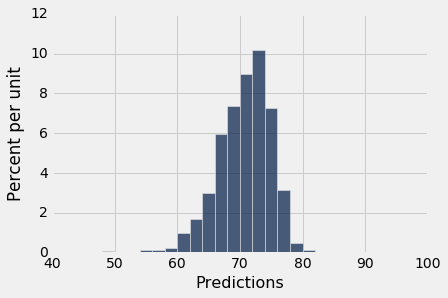

In [17]:
def sample_predict(new_x_value):
    predictions = Table(['Predictions'])
    for i in np.arange(1000):
        predicted = predict(hodgkins.sample(15), 'height', 'month15', new_x_value)
        predictions.append([predicted])
    predictions.hist(0, bins=np.arange(40, 96, 2))

sample_predict(160)

Using only 15 rows instead of all 22, the prediction could have come out differently from 70.7. This histogram shows how different the prediction might be. Almost all predictions fall between 60 and 80, but a few are outside of this range.

For an `x` value that is closer to the mean of all heights, the predictions from 15 rows are more tightly clustered.

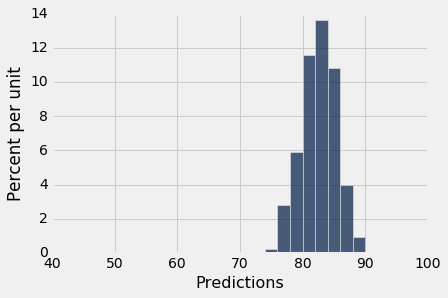

In [19]:
sample_predict(172)

In this histogram of the predictions for a height of 172, we see that almost all predictions fall between 74 and 90.

Predictions of values outside the typical observations of height vary wildly. A data scientist is rarely justified in extrapolating a linear trend beyond the range of values observed.

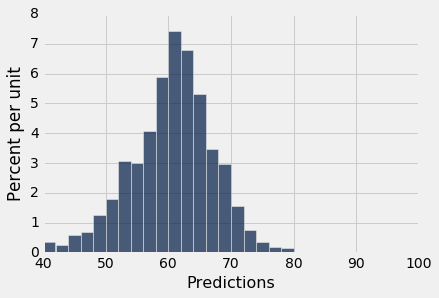

In [20]:
sample_predict(150)